<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Step 1: Mount Google Drive

drive.mount('/content/drive')

# Step 2: Clone the GitHub Repository
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git

# Step 3: Collect Paths and Labels

paths = []
labels = []

# Define the path to the dataset
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'

# Walk through the directory and collect file paths and labels
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        # Extract label from the filename
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

    # Break if we've collected a specified number of files, if needed
    if len(paths) == 2800:  # Adjust this number as necessary
        break

print('Dataset is Loaded')


Mounted at /content/drive
Cloning into 'SoundSense-Sentiment-Analysis'...
remote: Enumerating objects: 2827, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2827 (delta 0), reused 6 (delta 0), pack-reused 2818
Receiving objects: 100% (2827/2827), 213.27 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5602/5602), done.
Dataset is Loaded


In [5]:
len(paths)

2800

In [6]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_angry/YAF_ton_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_angry/YAF_wire_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_angry/YAF_sell_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_angry/YAF_thumb_angry.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_angry/YAF_luck_angry.wav']

In [7]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [8]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
1,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
2,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
3,/content/SoundSense-Sentiment-Analysis/TESS To...,angry
4,/content/SoundSense-Sentiment-Analysis/TESS To...,angry


In [9]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [10]:
df['label'].value_counts()

label
fear       600
neutral    600
angry      400
happy      400
ps         400
disgust    200
sad        200
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

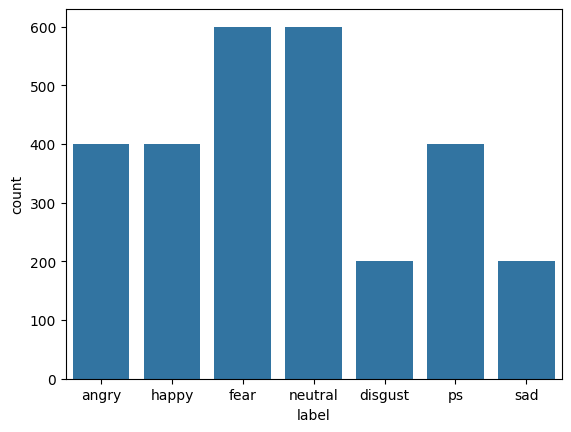

In [11]:
sns.countplot(data=df, x='label')

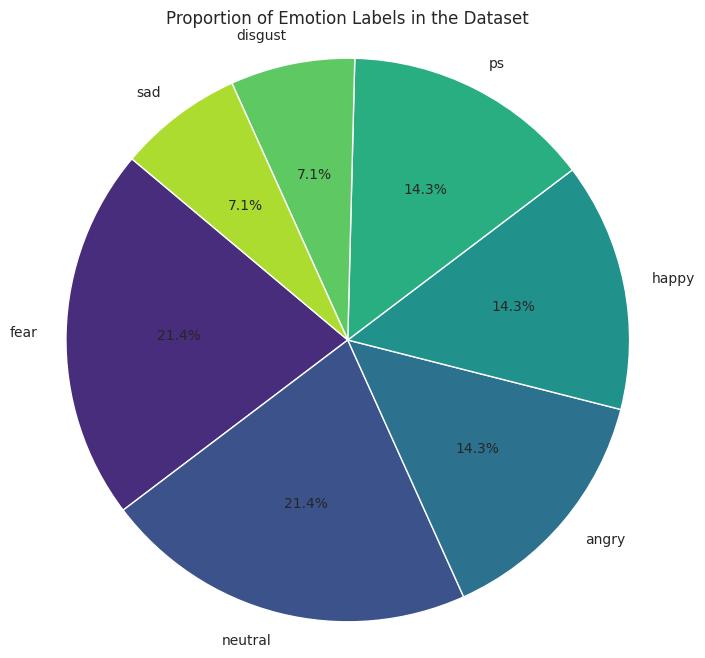

In [12]:
# Get label counts
label_counts = df['label'].value_counts()
# Data for the pie chart
labels = label_counts.index
counts = label_counts.values
colors = sns.color_palette('viridis', len(labels))
# Set Seaborn style
sns.set_style("whitegrid")
# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Emotion Labels in the Dataset')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [24]:
def plot_with_title(emotion, title, figsize=(10, 4), size=20):
    plt.figure(figsize=figsize)
    plt.title(f"{emotion}: {title}", fontsize=size, fontweight='bold', color='navy')

def waveplot(data, sr, emotion):
    plot_with_title(emotion, "Waveform")
    librosa.display.waveshow(data, sr=sr, color='dodgerblue', alpha=0.8, linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('Amplitude', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()

def mfcc(data, sr, emotion):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plot_with_title(emotion, "MFCCs", figsize=(10, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('MFCC Coefficients', fontsize=15, fontweight='bold', color='darkslategray')
    plt.tight_layout()
    plt.show()

def zero_crossing_rate(data, sr, emotion):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    plot_with_title(emotion, "Zero Crossing Rate", figsize=(10, 4))
    plt.plot(zcr[0], color='crimson')
    plt.xlabel('Frame', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('ZCR', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


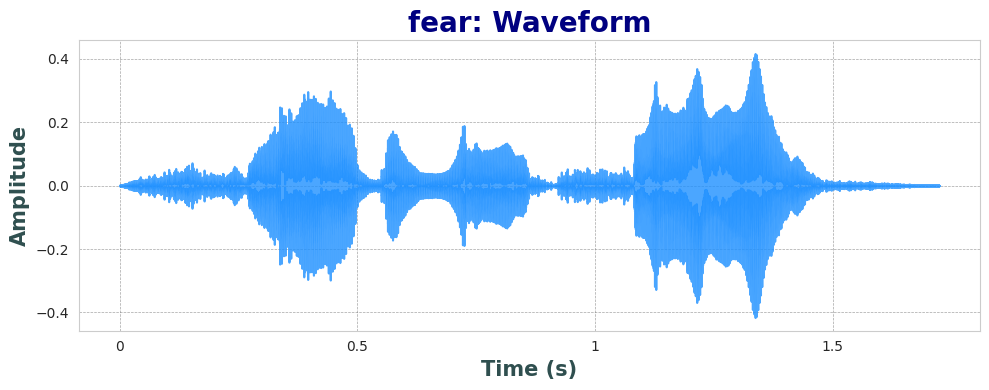

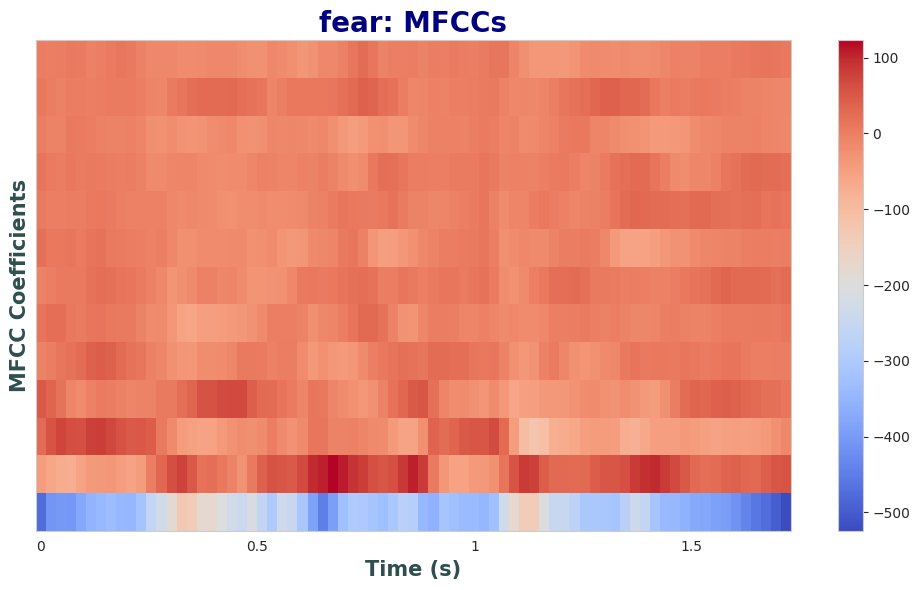

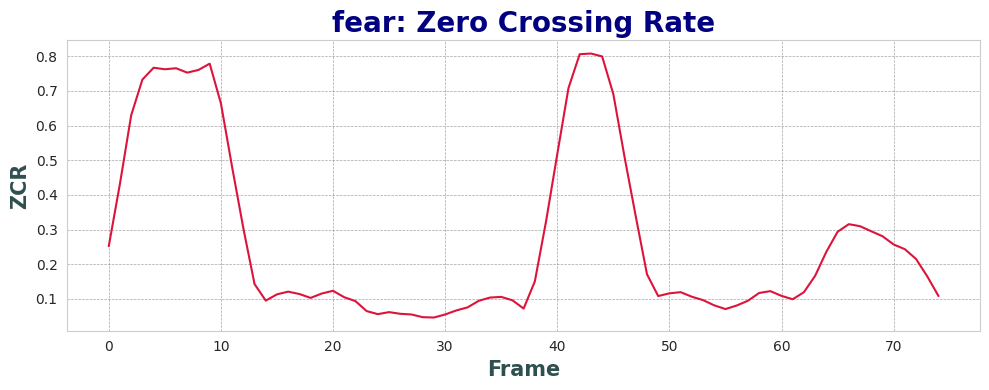

In [26]:
emotion = 'fear'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

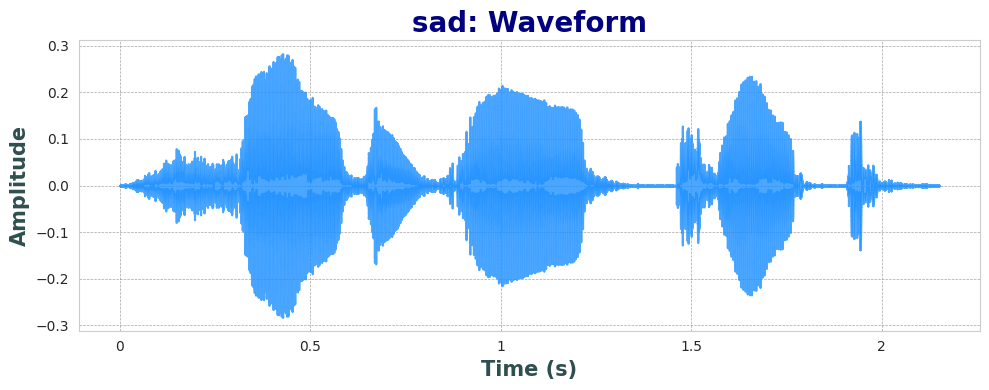

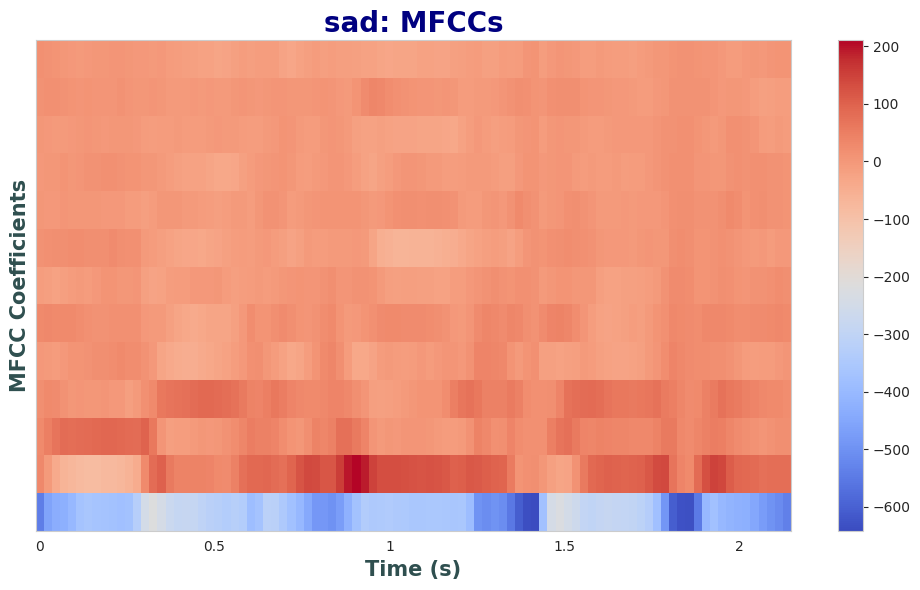

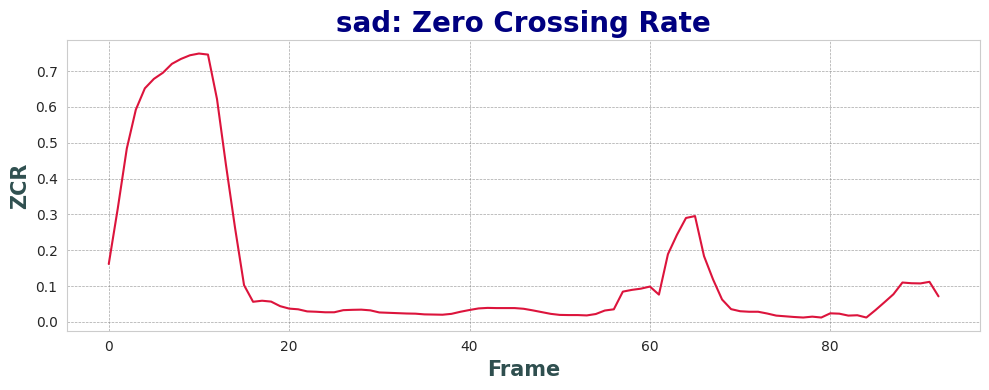

In [28]:
emotion = 'sad'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

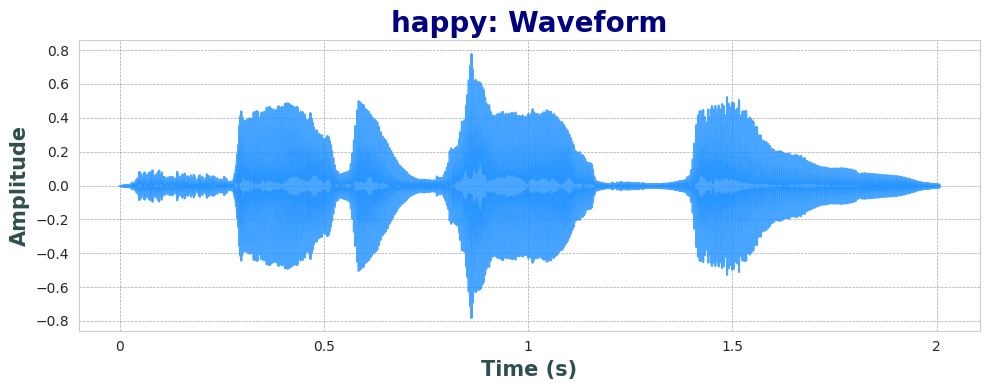

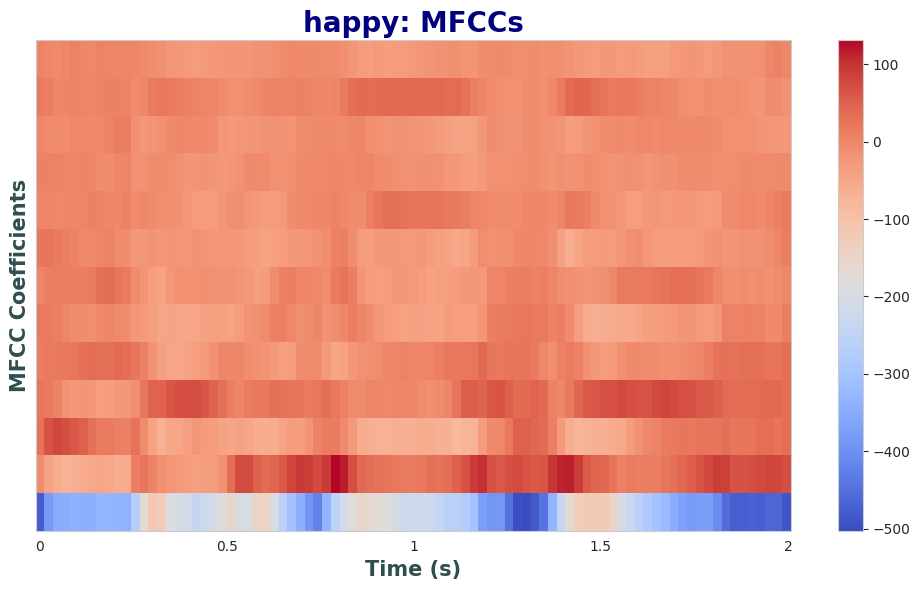

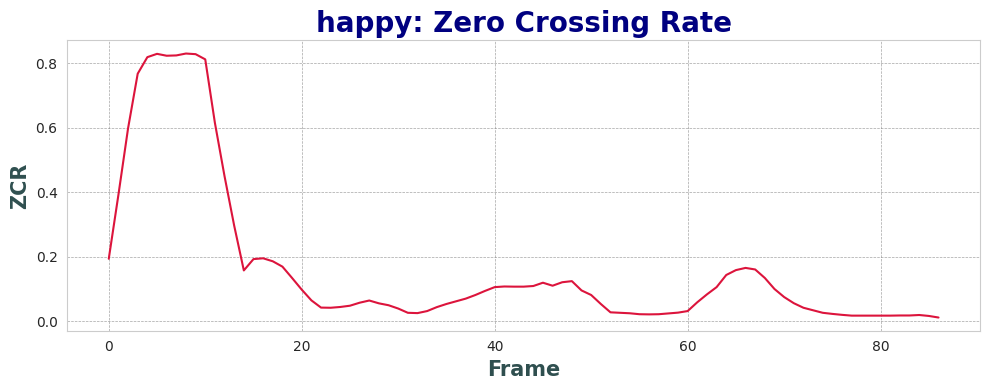

In [29]:
emotion = 'happy'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

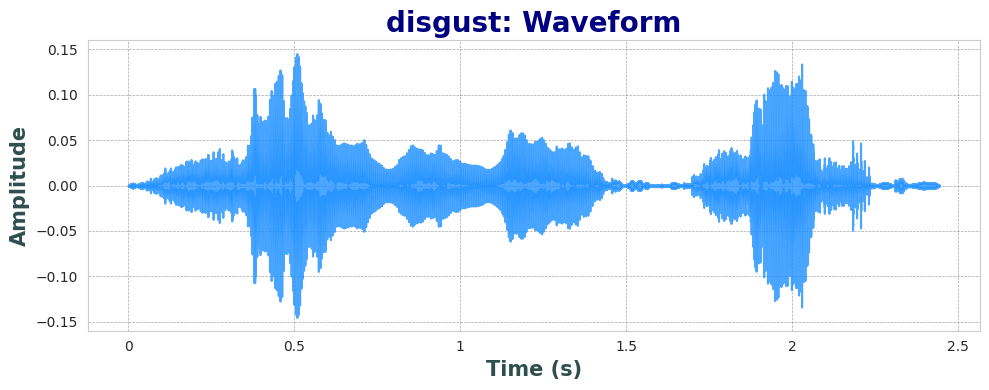

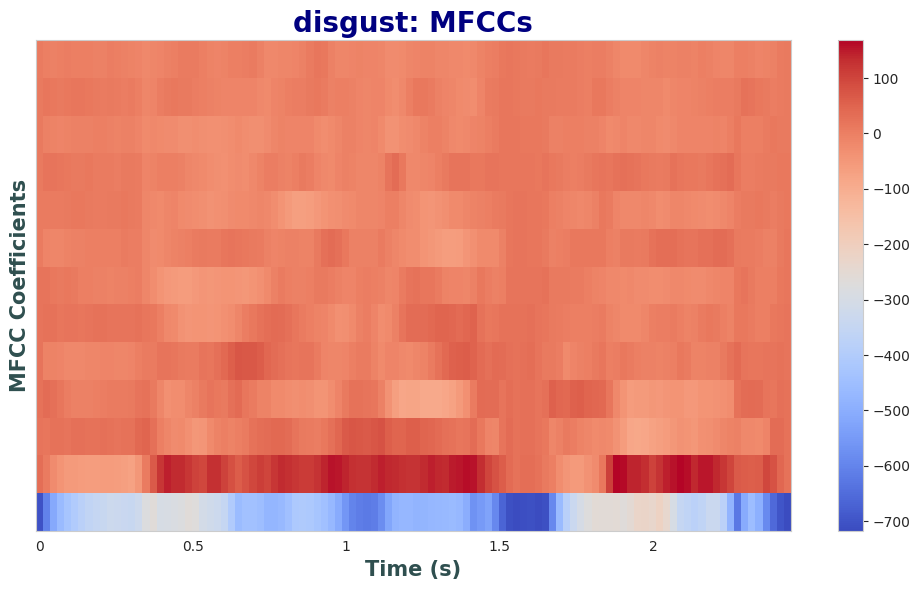

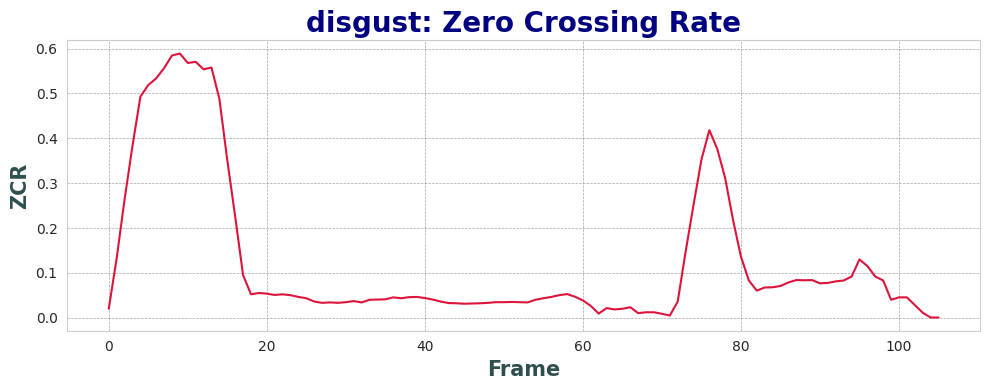

In [30]:
emotion = 'disgust'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

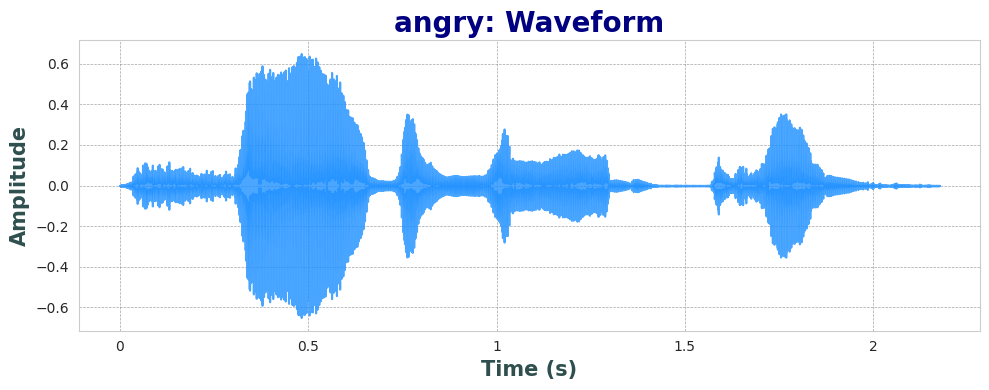

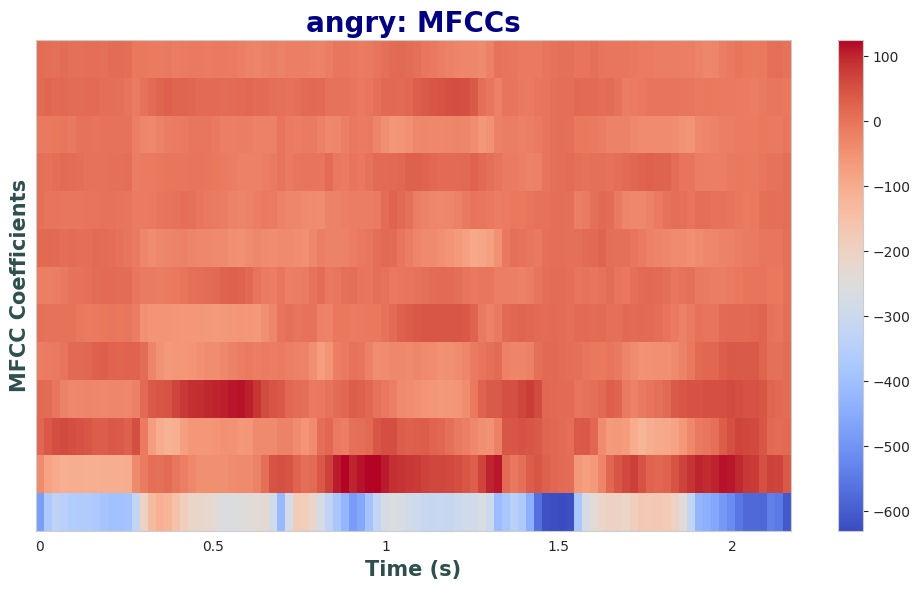

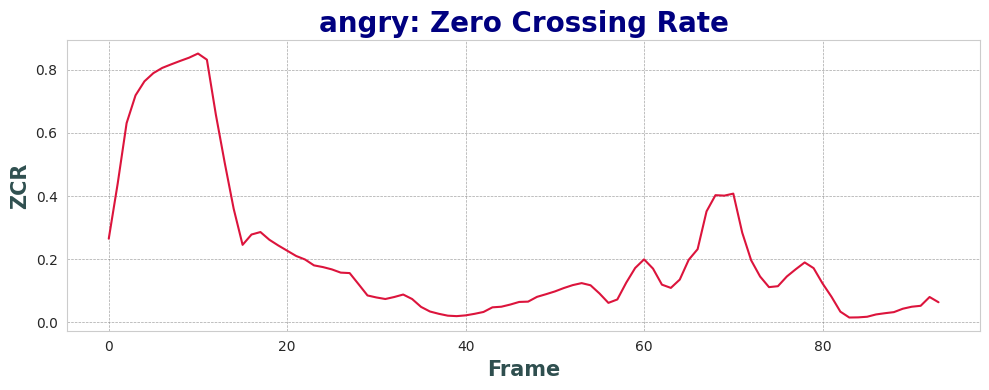

In [33]:
emotion = 'angry'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)